In [1]:
import matplotlib.pyplot as plt
from src.pvsys import ShadedArray
from typing import Sequence, Any
import numpy as np

In [2]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [
            CB91_Blue,
            CB91_Amber,
            CB91_Green,
            CB91_Violet,
            CB91_Pink,
            CB91_Purple,
            ]
              
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [3]:
IRRADIANCE_1 = 800
IRRADIANCE_2 = 500
TEMPERATURE_1 = 0
TEMPERATURE_2 = -0.62
CELL_TEMP_1 = ShadedArray.cell_temp_from_ambient(IRRADIANCE_1, TEMPERATURE_1)
CELL_TEMP_2 = ShadedArray.cell_temp_from_ambient(IRRADIANCE_2, TEMPERATURE_2)

pvsyss = ShadedArray.get_default_array()

plt.rc("text", usetex=True)
plt.rc("font", family="serif")

In [4]:
pvsyss.simulate(
    duty_cycle=0.0,
    irradiance=[IRRADIANCE_1, ] * 4,
    ambient_temperature=[TEMPERATURE_1, ] * 4,
)
uniform_curve_1 = pvsyss.get_shaded_iv_curve(curve_points=1000)
power_1 = pvsyss.power(uniform_curve_1.voltage, uniform_curve_1.current)
mpp_1 = pvsyss.mpp_from_curve(uniform_curve_1)
r1_mpp = mpp_1.voltage / mpp_1.current

pvsyss.simulate(
    duty_cycle=0.0,
    irradiance=[IRRADIANCE_2, ] * 4,
    ambient_temperature=[TEMPERATURE_2, ] * 4,
)
uniform_curve_2 = pvsyss.get_shaded_iv_curve(curve_points=1000)
power_2 = pvsyss.power(uniform_curve_2.voltage, uniform_curve_2.current)
mpp_2 = pvsyss.mpp_from_curve(uniform_curve_2)
r2_mpp = mpp_2.voltage / mpp_2.current

In [5]:
def get_intersection(x, y, ftol=1e-3):
    idx_1 = 0
    idx_2 = 0

    for i, (x_,y_) in enumerate(zip(x,y)):
        if abs(x_ - y_) <= ftol:
            idx_1 = i
            # return idx_1
            break
    else:
        raise RuntimeError("The lines don't insersect")

    for i, (x_,y_) in enumerate(zip(x,y)):
        if abs(y_ - x_) <= ftol:
            idx_2 = i

    return int(idx_1/2 + idx_2/2)

In [6]:
def rotation_degree(ax: plt.Axes, x_data: Sequence[Any], y_data: Sequence[Any]) -> float:
    "Calculate the rotation degree of the axis"
    p1 = ax.transData.transform_point((x_data[0], y_data[0]))
    p2 = ax.transData.transform_point((x_data[-1], y_data[-1]))
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])

    return np.degrees(np.arctan2(dy, dx))

In [7]:
r1 = mpp_1.voltage / mpp_1.current
r2 = mpp_2.voltage / mpp_2.current

r1_current = [v/r1 for v in uniform_curve_1.voltage]
r2_current = [v/r2 for v in uniform_curve_2.voltage]

r1_intersection = get_intersection(r1_current, uniform_curve_1.current, ftol=1e-2)
r2_intersection = get_intersection(r2_current, uniform_curve_2.current, ftol=1e-2)

r1_cross_inter = get_intersection(r1_current, uniform_curve_2.current, ftol=1e-2)
r2_cross_inter = get_intersection(r2_current, uniform_curve_1.current, ftol=4e-2)



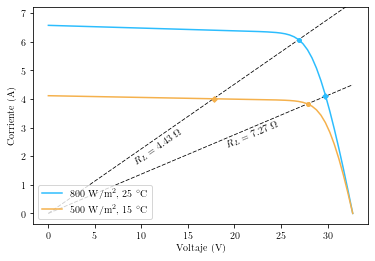

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel("Voltaje (V)")
ax.set_ylabel("Corriente (A)")

# Plot IV Curves
ax.plot(uniform_curve_1.voltage, uniform_curve_1.current, label=f'{IRRADIANCE_1} $\mathrm{{W/m^2}}$, {CELL_TEMP_1:0.0f} $^\circ \mathrm{{C}}$')
ax.plot(uniform_curve_2.voltage, uniform_curve_2.current, label=f'{IRRADIANCE_2} $\mathrm{{W/m^2}}$, {CELL_TEMP_2:0.0f} $^\circ \mathrm{{C}}$')

# Plot R Curves
ax.plot(uniform_curve_2.voltage, r1_current, linestyle='--', dashes=(5, 2), linewidth=0.8, color='black')
ax.plot(uniform_curve_2.voltage, r2_current, linestyle='--', dashes=(5, 2), linewidth=0.8, color='black')

# Reset plot color cycle
ax.set_prop_cycle(None)

# Plot MPPs
ax.plot(uniform_curve_1.voltage[r1_intersection], r1_current[r1_intersection], 'o', ms=4)
ax.plot(uniform_curve_2.voltage[r2_intersection], r2_current[r2_intersection], 'o', ms=4)

# Reset plot color cycle
ax.set_prop_cycle(None)

# Plot MPP projections
ax.plot(uniform_curve_2.voltage[r2_cross_inter], r2_current[r2_cross_inter], 'D', ms=4)
ax.plot(uniform_curve_1.voltage[r1_cross_inter], r1_current[r1_cross_inter], 'D', ms=4)

ax.set_ylim(top=max(uniform_curve_1.current)*1.1)

# Save current limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.set_prop_cycle(None)

# # Plot lines from MPP to x-axis
# ax.plot([uniform_curve_1.voltage[r1_intersection], ] * 2, [-100, r1_current[r1_intersection]], linestyle='--', dashes=(1, 5), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_intersection], ] * 2, [-100, r2_current[r2_intersection]], linestyle='--', dashes=(1, 5), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP to y-axis
# ax.plot([uniform_curve_1.voltage[r1_intersection], -10], [r1_current[r1_intersection], ] * 2, linestyle='--', dashes=(1, 5), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_intersection], -10], [r2_current[r2_intersection], ] * 2, linestyle='--', dashes=(1, 5), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP projections to x-axis
# ax.plot([uniform_curve_2.voltage[r2_cross_inter], ] * 2, [-100, r2_current[r2_cross_inter]], linestyle='--', dashes=(1, 10), linewidth=0.7)
# ax.plot([uniform_curve_1.voltage[r1_cross_inter], ] * 2, [-100, r1_current[r1_cross_inter]], linestyle='--', dashes=(1, 10), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP projections to y-axis
# ax.plot([uniform_curve_1.voltage[r1_cross_inter], -10], [r1_current[r1_cross_inter], ] * 2, linestyle='--', dashes=(1, 10), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_cross_inter], -10], [r2_current[r2_cross_inter], ] * 2, linestyle='--', dashes=(1, 10), linewidth=0.7)

# Restore limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# lines = ax.get_lines()
ax.text(9, 9/r1 - 0.3, f'$R_L={r1:0.2f} \, \, \Omega$', usetex=True, rotation=rotation_degree(ax, uniform_curve_1.voltage, r1_current), color='black')
ax.text(19, 19/r2 - 0.3, f'$R_L={r2:0.2f} \, \, \Omega$', usetex=True, rotation=rotation_degree(ax, uniform_curve_2.voltage, r2_current), color='black')

ax.legend(loc='lower left')

fig.savefig(r'output/ch2_10_iv_curve_intersection_load.pdf', bbox_inches='tight')

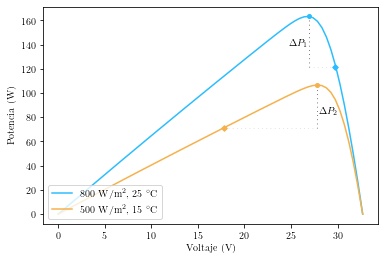

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel("Voltaje (V)")
ax.set_ylabel("Potencia (W)")

power_1 = pvsyss.power(uniform_curve_1.voltage, uniform_curve_1.current)
power_2 = pvsyss.power(uniform_curve_2.voltage, uniform_curve_2.current)
ax.plot(uniform_curve_1.voltage, power_1, label=f'{IRRADIANCE_1} $\mathrm{{W/m^2}}$, {CELL_TEMP_1:0.0f} $^\circ \mathrm{{C}}$')
ax.plot(uniform_curve_2.voltage, power_2, label=f'{IRRADIANCE_2} $\mathrm{{W/m^2}}$, {CELL_TEMP_2:0.0f} $^\circ \mathrm{{C}}$')

# # Plot MPP
# ax.plot(mpp_1.voltage, mpp_1.current * mpp_1.voltage, 'ok', ms=3)
# ax.plot(mpp_2.voltage, mpp_2.current * mpp_2.voltage, 'ok', ms=3)

# Save current limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.set_prop_cycle(None)

# # Plot lines from MPP to x-axisS
# ax.plot([uniform_curve_1.voltage[r1_intersection], ] * 2, [-100, r1_current[r1_intersection] * uniform_curve_1.voltage[r1_intersection]], linestyle='--', dashes=(1, 5), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_intersection], ] * 2, [-100, r2_current[r2_intersection] * uniform_curve_2.voltage[r2_intersection]], linestyle='--', dashes=(1, 5), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP to y-axis
# ax.plot([uniform_curve_1.voltage[r1_intersection], -10], [r1_current[r1_intersection] * uniform_curve_1.voltage[r1_intersection], ] * 2, linestyle='--', dashes=(1, 5), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_intersection], -10], [r2_current[r2_intersection] * uniform_curve_2.voltage[r2_intersection], ] * 2, linestyle='--', dashes=(1, 5), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP projections to x-axisS
# ax.plot([uniform_curve_2.voltage[r2_cross_inter], ] * 2, [-100, r2_current[r2_cross_inter] * uniform_curve_2.voltage[r2_cross_inter]], linestyle='--', dashes=(1, 10), linewidth=0.7)
# ax.plot([uniform_curve_1.voltage[r1_cross_inter], ] * 2, [-100, r1_current[r1_cross_inter] * uniform_curve_1.voltage[r1_cross_inter]], linestyle='--', dashes=(1, 10), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Plot lines from MPP projections to y-axis
# ax.plot([uniform_curve_1.voltage[r1_cross_inter], -10], [r1_current[r1_cross_inter] * uniform_curve_1.voltage[r1_cross_inter], ] * 2, linestyle='--', dashes=(1, 10), linewidth=0.7)
# ax.plot([uniform_curve_2.voltage[r2_cross_inter], -10], [r2_current[r2_cross_inter] * uniform_curve_2.voltage[r2_cross_inter], ] * 2, linestyle='--', dashes=(1, 10), linewidth=0.7)

# ax.set_prop_cycle(None)

# # Dummy plot to get the legend
# ax.plot([-100, -100], [-99, -99], label=f'$R_L={r1:0.2f} \, \, \Omega$')
# ax.plot([-100, -100], [-99, -99], label=f'$R_L={r2:0.2f} \, \, \Omega$')

# Plot lines from MPP to MPP projections, vertical
op_r1_x = [uniform_curve_1.voltage[r1_intersection], ] * 2
op_r1_y = [r2_current[r2_cross_inter] * uniform_curve_2.voltage[r2_cross_inter], r1_current[r1_intersection] * uniform_curve_1.voltage[r1_intersection]]
ax.plot(op_r1_x, op_r1_y, linestyle='--', dashes=(1, 5), linewidth=0.7, color='k')
ax.text(op_r1_x[0]*0.92, (op_r1_y[1] + op_r1_y[0])*0.49, f'$\Delta P_1$', usetex=True, color='k')


op_r2_x = [uniform_curve_2.voltage[r2_intersection], ] * 2
op_r2_y = [r1_current[r1_cross_inter] * uniform_curve_1.voltage[r1_cross_inter], r2_current[r2_intersection] * uniform_curve_2.voltage[r2_intersection]]
ax.plot(op_r2_x, op_r2_y, linestyle='--', dashes=(1, 5), linewidth=0.7, color='k')
ax.text(op_r1_x[0]*1.04, (op_r2_y[1] + op_r2_y[0])*0.47, f'$\Delta P_2$', usetex=True, color='k')


ax.set_prop_cycle(None)

# Plot lines from MPP to MPP projections, horizontal
op_r1_y = [r2_current[r2_cross_inter] * uniform_curve_2.voltage[r2_cross_inter], ] * 2
op_r1_x = [uniform_curve_1.voltage[r1_intersection], uniform_curve_2.voltage[r2_cross_inter]]
op_r2_y = [r1_current[r1_cross_inter] * uniform_curve_1.voltage[r1_cross_inter], ] * 2
op_r2_x = [uniform_curve_2.voltage[r2_intersection], uniform_curve_1.voltage[r1_cross_inter]]
ax.plot(op_r1_x, op_r1_y, linestyle='--', dashes=(1, 5), linewidth=0.7, color='0.8')
ax.plot(op_r2_x, op_r2_y, linestyle='--', dashes=(1, 5), linewidth=0.7, color='0.8')

# Reset plot color cycle
ax.set_prop_cycle(None)

# Plot MPP
ax.plot(uniform_curve_1.voltage[r1_intersection], r1_current[r1_intersection] * uniform_curve_1.voltage[r1_intersection], 'o', ms=4)
ax.plot(uniform_curve_2.voltage[r2_intersection], r2_current[r2_intersection] * uniform_curve_2.voltage[r2_intersection], 'o', ms=4)

# Reset plot color cycle
ax.set_prop_cycle(None)

# Plot MPP projections
ax.plot(uniform_curve_2.voltage[r2_cross_inter], r2_current[r2_cross_inter] * uniform_curve_2.voltage[r2_cross_inter], 'D', ms=4)
ax.plot(uniform_curve_1.voltage[r1_cross_inter], r1_current[r1_cross_inter] * uniform_curve_1.voltage[r1_cross_inter], 'D', ms=4)

# Restore limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.legend(loc='lower left')

fig.savefig(r'output/ch2_11_pv_curve_intersection_load.pdf', bbox_inches='tight')